# GDVSpectra

## Initialise GDVSpectra

### Load packages

In [1]:
# needs pymannkendall and ruptures

In [2]:
%matplotlib inline
%load_ext autoreload

import os, sys
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import datacube
sys.path.append('../Scripts')
from dea_datahandling import load_ard
from dea_dask import create_local_dask_cluster
from dea_plotting import display_map, rgb

sys.path.append('./modules')
import gdvspectra

sys.path.append('./shared')
import satfetcher, indices, tools

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Set up a dask cluster and ODC

In [3]:
# initialise the cluster. paste url into dask panel for more info.
create_local_dask_cluster()

# open up a datacube connection
dc = datacube.Datacube(app='gdvspectra')

Client Scheduler: tcp://127.0.0.1:46089 Dashboard: /user/lewis/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 13.11 GB


## Study area and data setup

### Set study area, time range, show map

In [4]:
# testing study area extent - yandi and roy hill
lat_extent, lon_extent = (-22.82901, -22.67901), (118.94980, 119.29979)  # yandi
#lat_extent, lon_extent = (-22.63461, -22.33461), (119.88111, 120.18111) # royhill

# display onto interacrive map
display_map(x=lon_extent, y=lat_extent)

### Load DEA ODC satellite data

In [5]:
# provide study area name
study_area = 'yandi'

# select start and end year range
time_range = ('1999', '2020')

# set datacube query parameters
platform = 'landsat'
bands = ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2']
#bands = ['nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir_1', 'nbart_swir_2'] # sentinel
min_gooddata = 0.90

# fetch satellite data from dea ard product
ds = satfetcher.load_dea_ard(platform=platform, 
                             bands=bands, 
                             x_extent=lon_extent, 
                             y_extent=lat_extent, 
                             time_range=time_range, 
                             min_gooddata=min_gooddata, 
                             use_dask=True)

# display dataset
#ds

Loading DEA ODC ARD satellite data.
Finding datasets
    ga_ls5t_ard_3


/home/jovyan/GDV_TOOL/../Tools/dea_tools/datahandling.py:237: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


    ga_ls7e_ard_3
    ga_ls8c_ard_3
Counting good quality pixels for each time step
Filtering to 338 out of 784 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Returning 338 time steps as a dask array
Satellite imagery fetched successfully.


### Conform band names

In [6]:
# rename dea bands to common standard
ds = satfetcher.conform_dea_ard_band_names(ds=ds, platform=platform)

# display dataset
#ds

Conforming DEA ARD satellite band names.
Satellite band names conformed successfully.


### Make a copy of raw dataset

In [7]:
# take a copy of dataset for cva later
ds_backup = ds.copy(deep=True)

## Generate seasonal vegetation and moisture data

### Reduce to wet (jfm) and dry (son) season months

In [8]:
# set wet and dry season month(s). we will use several per season
wet_month, dry_month = [1, 2, 3], [9, 10, 11] # note, fma and ond appear a better contrast

# get subset fo data for wet and dry season months
ds = gdvspectra.get_wet_dry_months(ds=ds, 
                                   wet_month=wet_month, 
                                   dry_month=dry_month)

# display dataset
#ds

Getting wet (JFM) and dry (SON) season months.
Reducing dataset into wet ([1, 2, 3]) and dry ([9, 10, 11]) months.
Got wet and dry seasons months successfully.


### Calculate vegetation and moisture indices

In [9]:
# calculate veg (mavi) and moist (ndmi) indices
ds = indices.calculate_indices(ds=ds, 
                               index=['mavi', 'ndmi'], 
                               custom_name=['veg_idx', 'mst_idx'], 
                               rescale=True, 
                               drop=True)

# display dataset
#ds

Calculating indices.
Calculating index: mavi
Calculating index: ndmi
Rescaled index values from -1 to 1 -> 0 to 2.
Renamed default indices.
Calculated indices successfully.


## Resample data

### Resample data to annual seasonal (djf and son) medians 

In [10]:
# perform resampling
ds = gdvspectra.resample_to_wet_dry_medians(ds=ds, 
                                            wet_month=wet_month, 
                                            dry_month=dry_month)

# display dataset
#ds

Resampling dataset down to annual, seasonal medians.
Resampled down to annual seasonal medians successfully.


### Persist memory

In [11]:
# we have some calcs to make, persist now
ds = ds.persist()

## Pre-process dataset (e.g., outlier removal, interpolation)

### Remove outliers via z-score

In [12]:
# check for outlier times and nullify whole image. warning: persists memory
ds = gdvspectra.nullify_wet_dry_outliers(ds=ds, 
                                         wet_month=wet_month, 
                                         dry_month=dry_month, 
                                         p_value=0.01)

# display dataset
#ds

Nullifying wet and dry season outliers usign z-score.
No outlier dates detected.
Nullified wet and dry season outliers successfully.


### Remove any years missing wet, dry season data

In [13]:
# drop any years from dataset where wet and dry seasons missing
ds = gdvspectra.drop_incomplete_wet_dry_years(ds)

# display dataset
#ds

Dropping years where num seasons not equal to 2 (wet and dry).
No incomplete years detected. No data was dropped.


### Fill empty data edges via backward and/or forward fill

In [14]:
# ! WARNING ! this func requires pre-computed data due to xr-dask bfill and ffill bug
# xr-dask bfill/ffill will perform but not update values in ds
# todo - remove this compute when bug fixed in ver > 0.18
ds = ds.compute()

In [15]:
# fill any empty first, last years using back/forward fill
ds = gdvspectra.fill_empty_wet_dry_edges(ds=ds,
                                         wet_month=wet_month, 
                                         dry_month=dry_month)

# display dataset
#ds

Filling empty wet and dry edges in dataset.
Filling wet season edges.
First time has values. No need to fill.
Last time has values. No need to fill.
Filling dry season edges.
First time has values. No need to fill.
Last time has values. No need to fill.
Filled empty wet and dry edges successfully.


### Interpolate missing data

In [16]:
# interpolate all missing pixels using full linear interpolation
ds = gdvspectra.interpolate_empty_wet_dry(ds=ds,
                                          method='full', 
                                          wet_month=wet_month, 
                                          dry_month=dry_month)

# display dataset
#ds

Interpolating empty values in dataset.
Interpolating using full method. This can take awhile. Please wait.
Interpolated empty values successfully.


## Standardise data

### Generate invariant targets and standardise

In [17]:
# standardise data to invariant targets derived from dry times
ds = gdvspectra.standardise_to_targets(ds=ds, 
                                       dry_month=dry_month, 
                                       q_upper=0.99, 
                                       q_lower=0.05)

# display dataset
#ds

Standardising data using invariant targets.
Getting Generating invariant targets.
Got orthogonal polynomial coefficients: [-21. -19. -17. -15. -13. -11.  -9.  -7.  -5.  -3.  -1.   1.   3.   5.
   7.   9.  11.  13.  15.  17.  19.  21.]
Got sum of squares: 3542 and constant 2: 
Standardising to invariant targets and rescaling via increasing sigmoidal.
Standardised using invariant targets successfully.


## Calculate seasonal similarity

In [18]:
# calculate standardised seaonal similarity (diff between wet, dry per year)
ds_similarity = gdvspectra.calc_seasonal_similarity(ds=ds,
                                                    wet_month=wet_month,
                                                    dry_month=dry_month,
                                                    q_mask=0.9)

# display dataset
#ds

Calculating seasonal similarity.
Rescaling via increasing-decreasing sigmoidal.
Masking similarity areas to higher vege and moist areas.
Calculated seasonal similarity successfully.


## Perform GDV likelihood modelling

### Generate likelihood model

Generating groundwater-dependent vegetation (GDV) model.
Generated groundwater-dependent vegetation model successfully


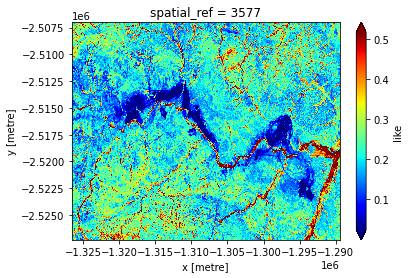

In [19]:
# generate gdv likelihood model using wet, dry, similarity variables
ds_like = gdvspectra.calc_likelihood(ds=ds, 
                                     ds_similarity=ds_similarity,
                                     wet_month=wet_month, 
                                     dry_month=dry_month)

# preview an all-time median of gdv likelihood. red is high likelihood
ds_like['like'].median('time').plot(robust=True, cmap='jet')

### Generate field occurrence points for thresholding

In [20]:
# set location of point shapefile with presence/absence column
#shp_path = r'../GDVSDM/data_testing/presence_points/presence_points.shp'
shp_path = r'./data/yandi_2_final_albers.shp'

# read shapefile as pandas dataframe
df_records = tools.read_shapefile(shp_path=shp_path)

# subset to just x, y, pres/abse column
df_records = tools.subset_records(df_records=df_records, p_a_column='GDV_ACT')

# display dataframe
#df_records

Reading records within shapefile.
Rows read from shapefile successfully.
Subsetting records from dataframe.
Subset records successfully.


### Threshold likelihood

Thresholding groundwater-dependent vegeation likelihood.
Thresholding dataset via occurrence records and AUC.
Clipping pandas dataframe records to xarray dataset.
Extracting cell resolution from dataset.
Resolution extracted successfully from dataset.
Extracted xarray dataset values successfully.
Removing records containing NoData (nan) values.
Removed 0 records containing NoData values successfully.
AUC: 0.719 for whole dataset.
Thresholded dataset successfully.
Thresholded likelihood succuessfully.


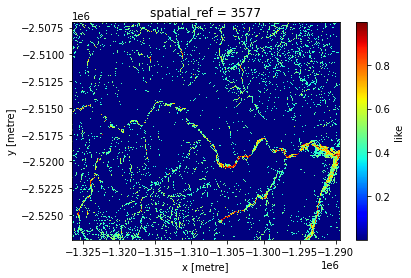

In [21]:
# perform thresholding using standard deviation on median likelihood
ds_thresh = gdvspectra.threshold_likelihood(ds=ds_like.median('time', keep_attrs=True), 
                                            df=df_records, 
                                            num_stdevs=3, 
                                            res_factor=3, 
                                            if_nodata='any')

# preview an all-time median of gdv likelihood thresholded
ds_thresh.where(~ds_thresh.isnull(), 0.001)['like'].plot(robust=False, cmap='jet')

## Perform trend analysis

### Calculate trends using Mann-Kendall trend analysis

Performing Mann-Kendall test (original).


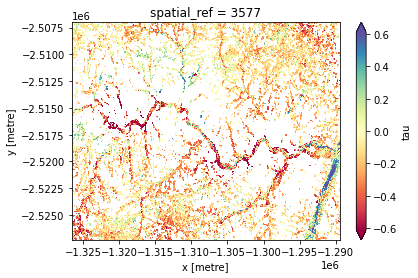

In [22]:
# create a mask where gdv highly likely
ds_mask = xr.where(~ds_thresh.isnull(), True, False)

# do mk to find sig. inc/dec trends in high likelihood areas
ds_mk = gdvspectra.perform_mk_original(ds=ds_like.where(ds_mask), 
                                        pvalue=None, 
                                        direction='both')

# show mk trends. blue is increasing, red is decreasing
ds_mk['tau'].plot(robust=True, cmap='Spectral')

### Calculate slope using Theil-Sen

Performing Theil-Sen slope (original).


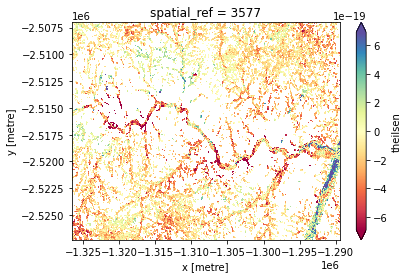

In [23]:
# create a mask where gdv highly likely
ds_mask = xr.where(~ds_thresh.isnull(), True, False)

# do theil sen slopes in high likelihood areas
ds_ts = gdvspectra.perform_theilsen_slope(ds=ds_like.where(ds_mask), 
                                       alpha=0.95)

# show mk trends. blue is increasing, red is decreasing
ds_ts['theilsen'].plot(robust=True, cmap='Spectral')

In [ ]:
# did not do seasonal mannkendall. we will imrpove with stl

In [ ]:
# export datasets to nc

## Peform Change Vector Analysis (CVA)

### Get specific months from dataset copy

In [25]:
# subset down to year/month/season 
# todo turn into func
cva_times = [9, 10, 11]
ds_backup = ds_backup.sel(time=ds_backup['time.month'].isin(cva_times))

### Generate tasselled cap greenness and brightness

In [26]:
%autoreload

# calculate tasselled cap greenness and brightness indices
ds_backup = indices.calculate_indices(ds=ds_backup, 
                                      index=['tcg', 'tcb'],
                                      rescale=False, 
                                      drop=True)

# display dataset
#ds_sub

Calculating indices.
Calculating index: tcg
Calculating index: tcb
Calculated indices successfully.


### Resample annual medians for selected dates

In [27]:
# write func to do this safely
ds_backup = ds_backup.resample(time='YS').median(keep_attrs=True)

### Perform Z-Score

In [28]:
# todo

### Interpolate missing times

In [29]:
# todo

### Standardise using invariant targets

In [30]:
# todo

### Perform Change Vector Analysis

In [31]:
# create a baseline and comparison dataset split
# can be one baseline image, a set of baselines, or all time
# same with comparison dates, one, many, or alltime

In [32]:
# create a empty dataset via full_like with nan
# add bunch of vars to it like angout, magout, magnitude etc

In [38]:
# persist
ds_backup = ds_backup.persist()

In [177]:
%autoreload

Performing CVA.
Doing CVA: 1.
Performed CVA successfully.


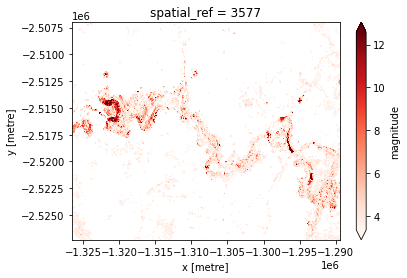

In [198]:
# generate cva comparing latest three years to baseline of 1999-2010
ds_cva = gdvspectra.perform_cva(ds=ds_backup.compute(),
                                base_times=(1999, 2010),
                                comp_times=(2018, 2020),
                                reduce_comp=True,
                                vege_var = 'tcg',
                                soil_var = 'tcb',
                                tmf=2)

# plot magnitude of all change from last 3 years to baseline decade
ds_cva['magnitude'].isel(time=0).plot(robust=True, cmap='Reds')

### Isolate specific change type

Isolating CVA angles from 90-180 degrees.
Isolated CVA angles successfully.


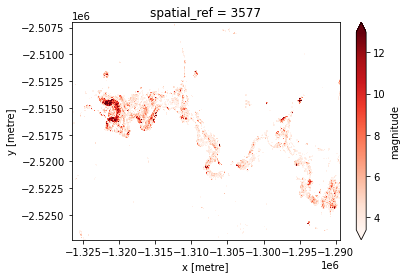

In [219]:
# isolate angles between 90-180 degrees to focus on veg decline only
ds_dec = isolate_cva_change(ds_cva, angle_min=90, angle_max=180)

# plot magnitude for veg decline areas
ds_dec['magnitude'].plot(robust=True, cmap='Reds')

### Intersect veg decline with GDV likelihood areas

In [220]:
# create a mask where gdv highly likely
ds_mask = xr.where(~ds_thresh.isnull(), True, False)

# select change areas where gdv exists
ds_final

